In [424]:
# common imports
import numpy as np
import pandas as pd
import joblib, glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports


# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

> Each participant has 3 csv files, one for each alignment state.
>

> Taking a look at a file should help gain insight to which DataFrame manipulations need to be implemented
> in the functions that will load the whole dataset.
>
> The 'HandRight' file contains right-hand movements which needs to be merged with the 'Alone' state files.
> Preparing it beforehand is more efficient since it will be used multiple times when loading the data.

In [529]:
# read right hand file
handright = pd.read_csv(r"extraFiles/HandRight.csv")

In [530]:
# display first 5 rows for a quick look
handright.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,0.270987,-0.017635,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,0.245085,-0.014770,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,0.230796,-0.008779,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,0.217681,-0.010759,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,0.220696,-0.017380,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [531]:
# DataFrame shape (rows, columns)
handright.shape

(4812, 22)

In [532]:
# description of data
handright.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [533]:
# show null values
handright.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [430]:
# should only contain 1 hand instances
handright[" # hands"].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [534]:
# should only contain right hand instances
handright[" Hand Type"].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: Identification number of detected movement
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position X: Center position of the palm from the leap origin, millimeters
6. Position Y:
7. Position Z:
8. Velocity X: Rate of change
9. Velocity Y:
10. Velocity Z:
11. Pitch:
12. Roll:
13. Yaw:
14. Wrist Pos X:
15. Wrist Pos Y:
16. Wrist Pos Z:
17. Elbow pos X:
18. Elbow pos Y:
19. Elbow pos Z:
20. Grab Strength:
21. Grab Angle:
22. Pinch Strength:

Clearly just by looking at a few files the data needs to be cleaned.

* Alone has instances with 2 hands and right hand in hand type that need to be removed. Likewise, spontaneous
and sync have instances with 1 hand and a mismatch between right and left hands.

In [520]:
def remove_first7(df):
    df.drop(df[df["Time"] < df["Time"].min() + 7].index, inplace=True)
    # drop is True to prevent from adding the old indices as a new column
    df.reset_index(drop=True, inplace=True)

In [521]:
print("Before:", handright.shape)
handright_prepared = handright.drop(handright[(handright[" Hand Type"] == "left") | (handright[" # hands"] == 2)].index)
handright_prepared.reset_index(drop=True, inplace=True)
print(handright_prepared.shape)
remove_first7(handright_prepared)  # right hand file without first 7 seconds
print(handright_prepared.shape)
handright_prepared.dropna(inplace=True)
print("After:", handright_prepared.shape)
print("Null values:", handright_prepared.isna().sum().sum())
handright_prepared.head()

Before: (4812, 22)
(4698, 22)
(4277, 22)
After: (3893, 22)
Null values: 0


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


In [522]:
# split right hand file for training and testing
train_size = round(len(handright_prepared) * 0.8)

handright_prepared_train = handright_prepared.loc[:train_size].copy()
handright_prepared_test = handright_prepared.loc[train_size:].copy()

print("Right Hand Train\nShape:", handright_prepared_train.shape,
      "\nNull Values:", handright_prepared_train.isna().sum().sum())
print()
print("Right Hand Test\nShape:", handright_prepared_test.shape,
      "\nNull Values:", handright_prepared_test.isna().sum().sum())

Right Hand Train
Shape: (3115, 22) 
Null Values: 0

Right Hand Test
Shape: (779, 22) 
Null Values: 0


> The following functions load the data into a DataFrame:

In [537]:
# function combines alone csv file with the right hand file

def combine_right(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat copies to a DataFrame
    right = right.loc[:len(df_alone) - 1]  # -1 because loc includes the end index, and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

In [538]:
# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    return left.merge(right, how="outer", on=["state", "time"])

In [539]:
train_path = "extraFiles/Training/**/*.csv"
test_path = "extraFiles/Validation/**/*.csv"


def load_data(path, as_pandas):
    data = []
    # glob searches all directories and files
    for filename in glob.iglob(path, recursive=True):
        df = pd.read_csv(filename, index_col=None, header=0)
        remove_first7(df)  # removes first 7 seconds from file
        if "Alone" in filename:
            if "Training" in path:
                df = combine_right(df, False)
            else:
                df = combine_right(df, True)
            df.insert(0, "state", 0)
        elif "Sync" in filename:
            df.insert(0, "state", 1)
        elif "Spontan" in filename:
            df.insert(0, "state", 2)
        df = transform_columns(df)
        data.append(df)
    if as_pandas:
        return pd.concat(data, axis=0, ignore_index=True)
    return data

In [540]:
# load the data
train_set = load_data(train_path, as_pandas=True)
test_set = load_data(test_path, as_pandas=True)

In [541]:
# display loaded data
train_set.head()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strenth_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strenth_right,grab_angle_right,pinch_strength_right
0,2,343.0061,-102.2870,198.3166,-2.122641,-174.57210,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.006620,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.000000,2.793122,0.329752
1,2,343.0227,-103.8721,201.4944,-2.063620,-178.50250,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.545550,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.000000,2.704073,0.293775
2,2,343.0392,-106.3691,207.4667,-2.337110,-126.78780,318.5284,-12.872290,1.441357,0.489946,1.496526,-168.4939,174.6985,-3.134404,-316.4541,-28.81729,-1.155143,0.0,1.865896,0.0,151.4056,203.4883,-38.14280,-14.11075,-56.448120,68.092860,0.637780,-0.134837,-0.554623,190.4547,169.7302,10.512530,324.1130,19.09524,161.3746,1.000000,2.422549,0.175940
3,2,343.0558,-107.9509,212.1324,-2.788956,-74.28078,244.4823,-30.771300,1.444497,0.483316,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.78214,-9.287997,0.0,1.899355,0.0,151.6132,202.9217,-37.08601,21.48209,-21.234860,51.146260,0.608950,-0.142477,-0.548808,190.8024,170.2935,12.170700,323.0928,17.14600,161.7030,1.000000,2.101400,0.052777
4,2,343.0723,-109.5427,216.8003,-3.337280,-96.49666,269.5434,-37.723870,1.431969,0.488396,1.491886,-171.4205,183.7144,-4.797314,-311.4874,-25.01130,-16.183130,0.0,1.950082,0.0,152.4920,202.8671,-36.85715,57.06179,4.746809,17.712610,0.568949,-0.165198,-0.553877,192.5801,172.1215,12.837430,325.7650,19.51061,162.1241,0.849696,1.878483,0.000000


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [546]:
hands = train_set.copy()

In [558]:
hands.head(2)

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strenth_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strenth_right,grab_angle_right,pinch_strength_right
0,2,343.0061,-102.2870,198.3166,-2.122641,-174.5721,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.0,2.793122,0.329752
1,2,343.0227,-103.8721,201.4944,-2.063620,-178.5025,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.0,2.704073,0.293775


In [547]:
hands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102167 entries, 0 to 102166
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   state                 102167 non-null  int64  
 1   time                  102167 non-null  float64
 2   position_x_left       102167 non-null  float64
 3   position_y_left       102167 non-null  float64
 4   position_z_left       102167 non-null  float64
 5   velocity_x_left       102167 non-null  float64
 6   velocity_y_left       102167 non-null  float64
 7   velocity_z_left       102167 non-null  float64
 8   pitch_left            102167 non-null  float64
 9   roll_left             102167 non-null  float64
 10  yaw_left              102167 non-null  float64
 11  wrist_pos_x_left      102167 non-null  float64
 12  wrist_pos_y_left      102167 non-null  float64
 13  wrist_pos_z_left      102167 non-null  float64
 14  elbow_pos_x_left      102167 non-null  float64
 15  

In [548]:
hands.isna().sum().sum()

0

In [549]:
hands.describe()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strenth_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strenth_right,grab_angle_right,pinch_strength_right
count,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000
mean,1.002359,530.008960,-108.399969,203.950690,33.658825,0.106481,-1.128087,0.126286,1.012147,0.748588,1.117443,-150.022211,165.290776,41.313122,-313.367382,4.700229,73.416430,0.118788,0.832527,0.197191,94.469941,214.089185,39.033394,0.349077,-0.651211,0.134265,0.815019,-0.619647,-0.672255,126.244548,175.079926,73.524119,268.249814,25.820468,188.454427,0.068597,0.526616,0.058539
std,0.816567,138.724538,52.362851,53.346913,55.405094,137.080996,209.651380,130.074743,0.945446,1.083639,0.869910,48.650688,48.950463,48.394754,61.070479,69.563213,65.676440,0.284081,0.919241,0.338187,61.618865,53.003825,53.854172,142.280749,241.883359,163.473760,0.594040,0.645034,0.617109,70.363094,48.625960,54.977122,95.461699,60.389329,103.685143,0.223330,0.713970,0.202877
min,0.000000,182.549200,-332.468400,46.700040,-175.192200,-2946.061000,-2549.699000,-4198.832000,-3.141397,-3.141498,-3.140881,-358.100700,-12.279810,-134.610200,-527.991100,-227.942600,-196.431400,0.000000,0.000000,0.000000,-871.496500,59.404940,-154.681500,-1997.961000,-3180.031000,-2419.239000,-3.139637,-3.138914,-3.116449,-897.085900,9.248903,-135.556000,-857.703900,-209.569100,-78.658120,0.000000,0.000000,0.000000
25%,0.000000,429.381000,-136.316350,167.599350,1.667917,-66.072265,-105.709350,-57.821390,0.664863,0.236738,0.774440,-177.818900,133.512600,13.102065,-353.121350,-41.125215,23.831945,0.000000,0.001525,0.000000,36.971700,179.127400,-0.238326,-52.162620,-115.275050,-71.103970,0.436145,-1.099465,-1.139872,54.339450,147.043750,31.044000,177.045800,-15.045350,103.456150,0.000000,0.052100,0.000000
50%,1.000000,532.579300,-103.385000,201.296700,33.615700,-1.970494,1.018222,1.701208,1.261354,0.892743,1.284521,-145.463300,160.501100,39.378630,-314.022800,-2.993422,70.696160,0.000000,0.532742,0.000000,111.306700,210.979800,40.478970,1.830977,-1.166616,-2.405588,0.779387,-0.603963,-0.572067,151.012900,169.163900,74.406900,295.458800,20.919660,165.764000,0.000000,0.269197,0.000000
75%,2.000000,631.065250,-76.851930,234.619850,66.620345,63.697845,107.884050,60.316635,1.602624,1.367630,1.608865,-116.354400,188.816500,66.953700,-275.624200,40.108850,123.431600,0.000000,1.307195,0.291127,143.366500,243.572500,70.040500,57.009865,112.338000,67.293880,1.269570,-0.029590,-0.139655,183.862750,197.680150,117.139100,345.523950,60.997240,287.562900,0.000000,0.637837,0.000000
max,2.000000,856.329500,73.487510,517.504200,276.203200,3735.420000,2775.949000,2460.510000,3.140658,3.141574,3.141453,22.004390,454.275400,250.608700,146.564800,459.916300,378.241500,1.000000,3.141593,1.000000,269.368900,585.819200,244.340100,933.766400,1383.845000,883.450300,3.136825,3.134909,3.123079,291.070900,595.047800,270.775600,503.926100,404.511100,518.593100,1.000000,3.141593,1.000000


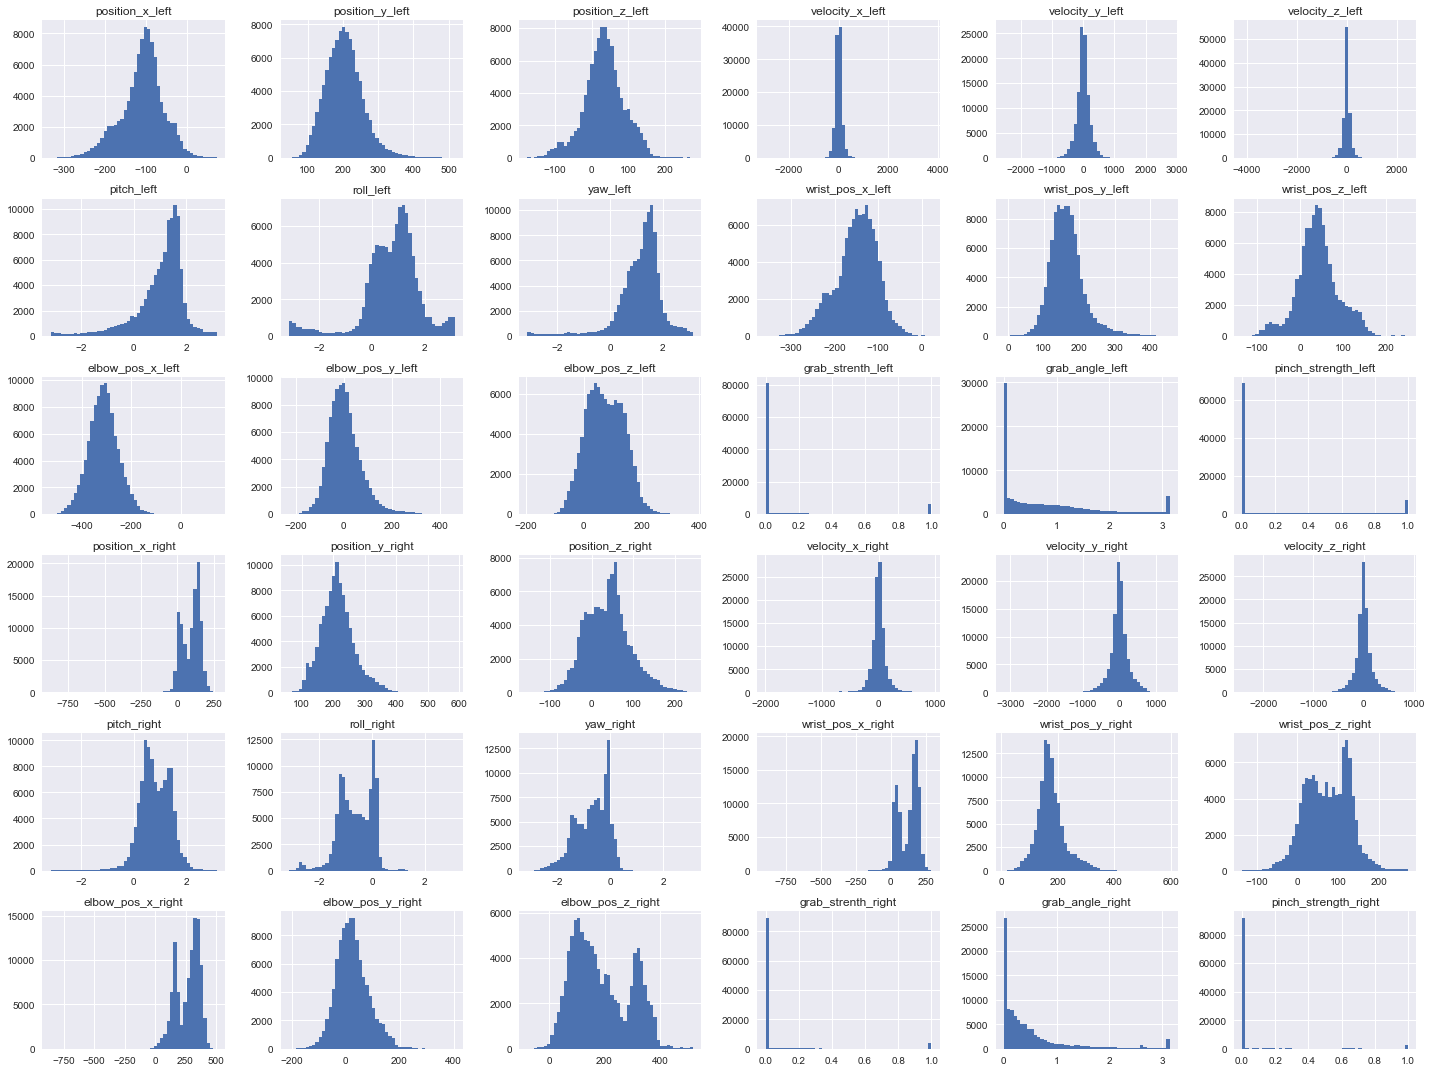

In [556]:
hands.drop(["state", "time"], axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
1. The attributes have different scales. Some values are between 0-1, while others are in the range of hundreds or
even thousands and contain negative values.
2. Most of the attributes have a relatively normal distribution. Some are a bit tail-heavy (extend farther to the
left or right).

### Notes:

01:37:00

- Organize the data in a pandas dataframe
- Goal: using the hand ... , detect if is alone, sync or spontaneous.
- "spontaneous synchronizing"
- interpersonal space
- training has 9 participants
- validation has different participants
- spontan and sync: if # hands is 1, remove data!
- time series
- every 2 lines is one feature (need to be combined) = 1 frame
- choose how many frames
- position y is similar
- 2 recordings, second is usually better
- can't split train and test as usual (correlation between each following movement). can't shuffle!
for instance, can take first 40 seconds for training and last 5 for testing.
- at least 2 seconds in between train and test
- model for 1 person, try model on second person. train the second person and test the third etc.
- 4 frames per second
-

> #### Resources:
1. Leap Motion Attributes <a href="https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html"
> title="leapmotion">link</a>

In [ ]:
# function splits training data into a training set and validations set
# 2 second difference between train and validation

def split_train_val(data):
    train = []
    val = []
    for i in range(len(data)):
        df = data[i]
        train.append(df.drop(df[df["time"] > df["time"].max() - 7].index)) # drop last 7 seconds
        val.append(df.drop(df[df["time"] < df["time"].max() - 5].index)) # append last 5 seconds
    trainX = pd.concat(train, axis=0, ignore_index=True)
    valX = pd.concat(val, axis=0, ignore_index=True)
    return trainX, valX

training_data = []

# glob searches all directories and files
for filename in glob.iglob("extraFiles/Training/**/*.csv", recursive=True):
    df = pd.read_csv(filename, index_col=None, header=0)
    remove_first7(df) # removes first 7 seconds from file
    if "Alone" in filename:
        df = combine_right(df, False)
        df.insert(0, "state", 0)
    elif "Sync" in filename:
        df.insert(0, "state", 1)
    elif "Spontan" in filename:
        df.insert(0, "state", 2)
    df = transform_columns(df)
    training_data.append(df)

In [ ]:
def transform_time(df):
    # adds a column with the second
    df["start_time"] = df.time.astype(int) - df.time.min().astype(int)
    start = df.start_time.min() + 7  # remove first 7 seconds
    first_7_seconds = df[df["start_time"] < start].index
    # drop is True to prevent from adding the old indices as a new column
    df_new = df.drop(first_7_seconds).reset_index(drop=True)
    # reset index (drop = False) adds round time as the left column in the DataFrame
    df = df.groupby("start_time").nth([0, 1, 2, 3]).reset_index()  # first four instances per second
    df.drop(df[df["start_time"] < df["start_time"].min() + 7].index).reset_index(drop=True)
    df.drop("start_time", axis=1, inplace=True)
    return df

alone["Time"] = alone["Time"] - alone["Time"].min()

    # reset index (drop = False) adds round time as the left column in the DataFrame
    df = df.groupby("start_time").nth([0, 1, 2, 3]).reset_index() # first four instances per second

In [ ]:
# adds a column with the second
merged["round_time"] = merged.time.astype(int) - merged.time.min().astype(int)

In [ ]:
# reset index (drop = False) adds round time as the left column in the DataFrame
merged = merged.groupby("round_time").nth([0, 1, 2, 3]).reset_index()

In [ ]:
# drop is True to prevent from adding the old indices as a new column
merged = merged.drop(merged[merged["round_time"] < merged.round_time.min() + 7].index).reset_index(drop=True)

In [ ]:
merged

In [ ]:
round_time_groups = merged.groupby("round_time")